In [109]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import json
import zipfile
import io
import os
import utm

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool, Legend, ColumnDataSource, Title
from bokeh.tile_providers import get_provider, CARTODBPOSITRON
from bokeh.models import GeoJSONDataSource

output_notebook()

Loading BokehJS ...

In [13]:
r = requests.get("https://datos.madrid.es/egob/catalogo/208627-32-transporte-ptomedida-historico.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
if not os.path.exists("data/2016"):
    os.mkdir("data/2016")
z.extractall("data/2016/")

In [131]:
len(jan_2016)

10570682

In [17]:
jan_2016 = pd.read_csv("data/2016/01-2016.csv", sep=";")
jan_2016.head()

,idelem,fecha,identif,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
0,3581,2016-01-01 09:15:00,61079,PUNTOS MEDIDA URBANOS,40,0,0,0,N,1
1,3982,2016-01-01 00:00:00,06042,PUNTOS MEDIDA URBANOS,52,0,2,0,N,13
2,4291,2016-01-01 09:15:00,16013,PUNTOS MEDIDA URBANOS,43,4,12,0,N,7
3,4200,2016-01-01 09:15:00,14002,PUNTOS MEDIDA URBANOS,52,0,4,0,N,14
4,5928,2016-01-01 09:15:00,44030,PUNTOS MEDIDA URBANOS,124,0,6,0,N,13


In [19]:
jan_2016["idelem"].unique().shape

(3797,)

In [20]:
r = requests.get("https://datos.madrid.es/egob/catalogo/202468-2-intensidad-trafico.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
if not os.path.exists("data/traffic_points"):
    os.mkdir("data/traffic_points")
z.extractall("data/traffic_points/")

In [104]:
def get_lat_lon(row):

    # 30 and 'T' is the zone of Madrid
    lat, lon = utm.to_latlon(row["st_x"], row["st_y"], 30, "T")
    
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + 
        lat * (np.pi/180.0)/2.0)) * scale

    return pd.Series([lat, lon, x, y])

In [105]:
traffic_points = pd.read_csv("data/traffic_points/pmed_trafico_03052016.csv", sep=";")

traffic_points[["latitude", "longitude", "utm_x", "utm_y"]] = traffic_points.apply(get_lat_lon, axis=1)

traffic_points.head()

,idelem,tipo_elem,cod_cent,nombre,st_x,st_y,latitude,longitude,utm_x,utm_y
0,1044,494,03FT08PM01,03FT08PM01,438963.314635,4.474734e+06,40.421001,-3.719488,-414051.481782,4.927311e+06
1,3600,494,PM30901,PM30901,443729.047369,4.473268e+06,40.408129,-3.663184,-407783.811885,4.925429e+06
2,3705,494,PM41451,PM41451,439858.261097,4.471574e+06,40.392598,-3.708640,-412843.963659,4.923159e+06
3,6823,494,PM41453,PM41453,439188.095183,4.470895e+06,40.386431,-3.716471,-413715.710072,4.922257e+06
4,7033,495,01015,Pº Castellana S-N - Pl. Colon-Hermosilla,441569.555897,4.475502e+06,40.428107,-3.688839,-410639.639249,4.928350e+06


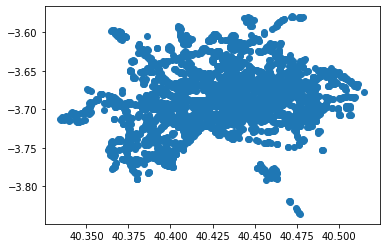

In [98]:
plt.scatter(traffic_points["utm_x"], traffic_points["utm_y"])

In [132]:
with open("data/districts/districts.geojson", "r") as geojson:
    geodata = json.load(geojson)

# for i in range(len(geodata['features'])):
#     geodata['features'][i]['properties']['Color'] = ['blue', 'red'][i%2]

In [139]:
g_data = np.array(geodata["features"][0]["geometry"]["coordinates"][0])

[[441184.7839999996, 4473200.78],
 [441181.2439999991, 4473184.23],
 [441178.8839999987, 4473160.910000001],
 [441140.85399999935, 4473176.92],
 [441126.35500000074, 4473191.33],
 [441121.81500000105, 4473194.6],
 [441116.5050000003, 4473195.61],
 [441104.68500000064, 4473193.341],
 [441003.9349999999, 4473158.581000001],
 [440993.6050000011, 4473163.620999999],
 [440783.9759999989, 4473093.142999999],
 [440778.2160000011, 4473091.003],
 [440656.1269999998, 4473047.613999999],
 [440596.2269999992, 4473026.504],
 [440519.3780000002, 4473001.305],
 [440385.94799999887, 4472954.316],
 [440350.318, 4472954.016],
 [440272.918999999, 4472969.567],
 [440050.8999999995, 4473024.688999999],
 [440000.9530000007, 4473038.581],
 [439890.40099999885, 4473069.33],
 [439794.2919999993, 4473093.231],
 [439762.43199999904, 4473099.351],
 [439646.4429999998, 4473126.031999999],
 [439613.0330000005, 4473137.673],
 [439581.69399999984, 4473146.782999999],
 [439442.7450000008, 4473225.554],
 [439312.776000

In [125]:
p = figure(title="My first interactive plot!", x_axis_type="mercator", y_axis_type="mercator")

geo_source = GeoJSONDataSource(geojson=json.dumps(geodata))

p.circle(x='x', y='y', size=15, color="green", alpha=0.7, source=geo_source)

source = ColumnDataSource(traffic_points)
p.circle(x="utm_x", y="utm_y",  size=2, color="red", source=source)

cartodb = get_provider(CARTODBPOSITRON)
p.add_tile(cartodb)

show(p)